In [75]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import cv2

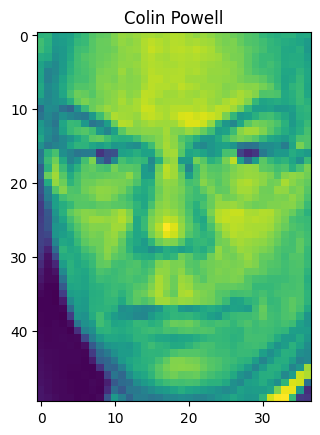

Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Tony Blair


In [245]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)
X, y = lfw_people.images, lfw_people.target
names = lfw_people.target_names

i = np.random.randint(0, 529)
plt.imshow(X[i])
plt.title(f'{names[y[i]]}')
plt.show()

for name in names: print(name)

In [132]:
X = X[..., np.newaxis]
print(X.shape)  # This will output (1288, 50, 111, 1)

(1140, 50, 37, 1)


In [133]:
# data preprocessing, gonna try aggressive augmentation
# converting to grayscale, equalizing
# def equalize(img):
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # convert to grayscale
#     img = cv2.equalizeHist(img)        # Apply histogram equalization
#     return img

X, y = shuffle(X, y, random_state=42)

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 
)

datagen.fit(X)

train = datagen.flow(
    X, 
    y, 
    batch_size = 32,
    subset = 'training'
)

test = datagen.flow(
    X,
    y,
    batch_size = 32, 
    subset= 'validation'
)

In [10]:
# if poor performance, balance and shuffle the data
X_tr, X_te, y_tr, y_te = train_test_split(X, y,test_size=0.2, random_state=42)

def equalize(img):
    return
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    horizontal_flip = True
)
# could try converting images to grayscale
X = np.array([equalize(img) for img in X])
datagen.fit(X)


In [145]:
# building the model
shape = (50, 37, 1)
def siamese_network(): # will use if regular architecture is trash
    input = Input(shape)
    model = Sequential()

    model.add(Conv2D(64, (5, 5), activation='relu', input_shape=shape))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(128, (5, 5), activation='relu', input_shape=shape))
    model.add(MaxPooling2D(2, 2))
    

    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))

    a, b = Input(shape), Input(shape)
    a, b = model(a), model(b)

    l1_dist = tf.abs(a-b)
    prediction = Dense(1, activation='sigmoid')(l1_dist)
    
    return Model(inputs=[a, b], output=prediction)

def cnn():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=shape))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))

    # model.add(Conv2D(512, (5, 5), activation='relu'))
    # model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(Dense(5, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def cnn2():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(5, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = cnn()
model2 = cnn2()

model.summary()
model2.summary()


/Users/suprita/Desktop/supriML/galaxy_classification/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_153 (Conv2D)             │ (None, 48, 35, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_147               │ (None, 24, 17, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 22, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_148               │ (None, 11, 7, 128)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_155 (Conv2D)             │ (None, 9, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_149               │ (None, 4, 2, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_47 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 895,493 (3.42 MB)

 Trainable params: 895,493 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_156 (Conv2D)             │ (None, 50, 37, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 50, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_150               │ (None, 25, 18, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 25, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 25, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_151               │ (None, 12, 9, 128)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_158 (Conv2D)             │ (None, 12, 9, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 12, 9, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_152               │ (None, 6, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 6, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 6, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_153               │ (None, 3, 2, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,629 (2.24 MB)

 Trainable params: 585,477 (2.23 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [158]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
model.fit(train, validation_data=test, epochs=20, callbacks=[reduce_lr])

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4670 - loss: 1.5390 - val_accuracy: 0.4649 - val_loss: 1.4131 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4412 - loss: 1.4735 - val_accuracy: 0.4649 - val_loss: 1.4086 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4603 - loss: 1.4506 - val_accuracy: 0.4649 - val_loss: 1.4184 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4564 - loss: 1.4334 - val_accuracy: 0.4649 - val_loss: 1.4179 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4486 - loss: 1.4619 - val_accuracy: 0.4649 - val_loss: 1.4095 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4790 - loss: 1.4114 - val_accuracy: 0.4649 - val_loss: 1.4062 - learning_rate: 2.0000e-04
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4365 - loss: 1.4238 - val

In [154]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.9661016949152542,
 1: 1.884297520661157,
 2: 0.43018867924528303,
 3: 2.091743119266055,
 4: 1.5833333333333333}

In [157]:

class_weights = dict(enumerate(class_weights))
model2.fit(train, validation_data=test, epochs=20, callbacks=[reduce_lr], class_weight=class_weights)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6863 - loss: 1.7690 - val_accuracy: 0.6754 - val_loss: 0.8810 - learning_rate: 1.0000e-06
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6300 - loss: 1.9605 - val_accuracy: 0.6579 - val_loss: 0.9654 - learning_rate: 1.0000e-06
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6348 - loss: 1.9681 - val_accuracy: 0.6404 - val_loss: 0.9590 - learning_rate: 1.0000e-06
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6599 - loss: 1.7918 - val_accuracy: 0.6184 - val_loss: 0.9486 - learning_rate: 1.0000e-06
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5930 - loss: 2.0847 - val_accuracy: 0.6754 - val_loss: 0.8814 - learning_rate: 1.0000e-06
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6363 - loss: 1.9189 - val_accuracy: 0.6316 - val_loss: 0.9261 - learning_rate: 1.0000e-06
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6384 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


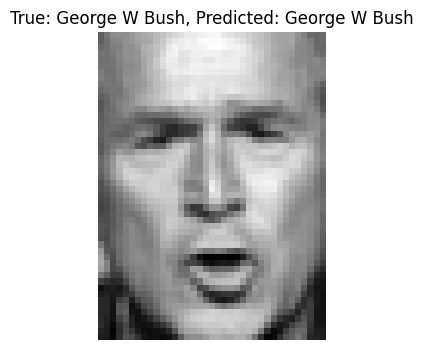

In [241]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_face_with_prediction(model, X_test, y_test, class_names):
    # Select a random index
    idx = np.random.randint(0, len(X_test))

    img = X_test[idx]
    true_label = y_test[idx]

    img_expanded = np.expand_dims(img, axis=0)  # Add batch dimension
    predicted_label = np.argmax(model.predict(img_expanded), axis=1)[0]


    plt.figure(figsize=(4, 4))
    plt.imshow(img.squeeze(), cmap='gray')

    
    plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[predicted_label]}")
    plt.axis('off')
    plt.show()


class_names = ['Colin Powell','Donald Rumsfeld','George W Bush','Gerhard Schroeder','Tony Blair']
plot_random_face_with_prediction(model, X, y, class_names)

In [95]:
X_rgb = np.repeat(X, 3, axis=-1)
print(X_rgb.shape)  # Outputs: (1288, 50, 37, 3)

(1288, 50, 37, 3)


In [166]:
# second cnn's pretty good, gonna try transfer learning

train = datagen.flow(X_rgb, y, batch_size=32, subset='training')
test = datagen.flow(X_rgb, y, batch_size=32, subset='validation')
def vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 37, 3))
    base_model.trainable = True

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model3 = vgg16()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-4)

model3.fit(train, validation_data=test, epochs=10, callbacks=[reduce_lr], class_weight=class_weights)


Epoch 1/10


/Users/suprita/Desktop/supriML/galaxy_classification/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 414ms/step - accuracy: 0.3264 - loss: 3.3154 - val_accuracy: 0.4649 - val_loss: 2.0325 - learning_rate: 0.0010
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 448ms/step - accuracy: 0.3652 - loss: 2.5491 - val_accuracy: 0.4649 - val_loss: 1.8771 - learning_rate: 0.0010
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 445ms/step - accuracy: 0.4357 - loss: 2.2630 - val_accuracy: 0.4649 - val_loss: 2.0198 - learning_rate: 0.0010
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 484ms/step - accuracy: 0.3910 - loss: 2.3287 - val_accuracy: 0.4649 - val_loss: 2.0552 - learning_rate: 0.0010
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step - accuracy: 0.4586 - loss: 2.1838 - val_accuracy: 0.4649 - val_loss: 2.1056 - learning_rate: 0.0010
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 492ms/step - accuracy: 0.3757 - loss: 2.2462 - val_accuracy: 0.4649 - val_loss: 2.1078 - learning_rate: 2.0000e-04
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 487ms/step - accuracy: 0.4303 - loss: 2.2893 - 

In [164]:
X_rgb.shape

(1140, 50, 37, 3)

In [163]:
from tensorflow.keras.applications import ResNet50

train_rgb = datagen.flow(X_rgb, y, batch_size=32, subset='training')
test_rgb = datagen.flow(X_rgb, y, batch_size=32, subset='validation')
def resnet():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 37, 3))
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model4 = resnet()
model4.fit(train_rgb, validation_data=test_rgb, epochs=10, class_weight=class_weights, callbacks=[reduce_lr, early_stop])

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - accuracy: 0.2211 - loss: 8.6405 - val_accuracy: 0.2193 - val_loss: 6.5626 - learning_rate: 1.0000e-05
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.3277 - loss: 7.8822 - val_accuracy: 0.2193 - val_loss: 6.6524 - learning_rate: 1.0000e-05
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.3562 - loss: 7.8336 - val_accuracy: 0.2193 - val_loss: 6.5458 - learning_rate: 1.0000e-05
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.3552 - loss: 7.5063 - val_accuracy: 0.4649 - val_loss: 6.4225 - learning_rate: 1.0000e-05
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 287ms/step - accuracy: 0.3857 - loss: 7.5144 - val_accuracy: 0.4649 - val_loss: 6.5896 - learning_rate: 1.0000e-05
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - accuracy: 0.3655 - loss: 7.4495 - val_accuracy: 0.4649 - val_loss: 7.2401 - learning_rate: 1.0000e-05
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 256ms/step - accuracy: